In [55]:
import os
import json
import copy
import collections
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.base import BaseEstimator
import torch
from torch import nn
import bnlearn as bn
import networkx as nx

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
DATA_DIR = "/shared/sets/datasets/vision/artificial_shapes/dependencies/dependenciesDEF_size64_len10000_cbF_cfT_noF"
OOD_DATA_DIR = "/shared/sets/datasets/vision/artificial_shapes/dependencies/dependenciesOOD_size64_len7500_cbF_cfT_noF"

In [7]:
with open(os.path.join(DATA_DIR, 'data.txt'), 'r') as f:
    data = [json.loads(line) for line in f]

In [11]:
def load_label(label_file):
    rid2name = list()   # rid: real id, same as the id in label.txt
    id2rid = list()     # id: number from 0 to len(rids)-1 corresponding to the order of rids
    rid2id = list()     
    with open(label_file) as l:
        rid2name_dict = collections.defaultdict(str)
        id2rid_dict = collections.defaultdict(str)
        rid2id_dict = collections.defaultdict(str)
        new_id = 0 
        for line in l.readlines():
            line = line.strip('\n\r').split(';')
            if len(line) == 3: # attr description
                if len(rid2name_dict) != 0:
                    rid2name.append(rid2name_dict)
                    id2rid.append(id2rid_dict)
                    rid2id.append(rid2id_dict)
                    rid2name_dict = collections.defaultdict(str)
                    id2rid_dict = collections.defaultdict(str)
                    rid2id_dict = collections.defaultdict(str)
                    new_id = 0
                rid2name_dict["__name__"] = line[2]
                rid2name_dict["__attr_id__"] = line[1]
            elif len(line) == 2: # attr value description
                rid2name_dict[line[0]] = line[1]
                id2rid_dict[new_id] = line[0]
                rid2id_dict[line[0]] = new_id
                new_id += 1
        if len(rid2name_dict) != 0:
            rid2name.append(rid2name_dict)
            id2rid.append(id2rid_dict)
            rid2id.append(rid2id_dict)
    return rid2name, id2rid, rid2id

In [12]:
rid2name, id2rid, rid2id = load_label(os.path.join(DATA_DIR, 'label.txt'))

In [14]:
data, rid2name, id2rid, rid2id

([{'box': {'y': 0, 'x': 0, 'w': 64, 'h': 64},
   'box_id': 'e0x',
   'image_id': 'e0x',
   'image_file': '/shared/sets/datasets/vision/artificial_shapes/dependencies/dependenciesDEF_size64_len10000_cbF_cfT_noF/images/image_0.jpg',
   'id': ['no_disk', 'yes_square', 'no_triangle', 'no_star'],
   'size': {'width': 64, 'height': 64}},
  {'box': {'y': 0, 'x': 0, 'w': 64, 'h': 64},
   'box_id': 'e1x',
   'image_id': 'e1x',
   'image_file': '/shared/sets/datasets/vision/artificial_shapes/dependencies/dependenciesDEF_size64_len10000_cbF_cfT_noF/images/image_1.jpg',
   'id': ['no_disk', 'yes_square', 'no_triangle', 'yes_star'],
   'size': {'width': 64, 'height': 64}},
  {'box': {'y': 0, 'x': 0, 'w': 64, 'h': 64},
   'box_id': 'e2x',
   'image_id': 'e2x',
   'image_file': '/shared/sets/datasets/vision/artificial_shapes/dependencies/dependenciesDEF_size64_len10000_cbF_cfT_noF/images/image_2.jpg',
   'id': ['no_disk', 'yes_square', 'no_triangle', 'yes_star'],
   'size': {'width': 64, 'height': 64

In [ ]:
def load_artificial_shapes_dataset(datadir, datatxt, labeltxt, targettxt):
    dataset = []
    labels = []
    with open(datatxt, 'r') as f:
        for line in f:
            data = json.loads(line)
            image_file = os.path.join(datadir, data['image_file'])
            dataset.append(plt.imread(image_file))
    with open(targettxt, 'r') as f:
        for line in f:
            labels.append(json.loads(line))
    return np.array(dataset), labels

In [18]:
dataset, labels = load_artificial_shapes_dataset(DATA_DIR, os.path.join(DATA_DIR, 'data.txt'), os.path.join(DATA_DIR, 'label.txt'), os.path.join(DATA_DIR, 'target.txt'))

In [23]:
def create_binary_matrix(indices, num_cols):
    return np.array([[1 if j in row else 0 for j in range(num_cols)] for row in indices])

In [24]:
shapes = ['disk', 'square', 'triangle', 'star', 'hexagon', 'pentagon']
label_ids = []
K_calc = 0
shape2ix = {shape: i for i, shape in enumerate(shapes)}
for labels1 in labels:
    labels1 = [shape2ix[l[0]] for l in labels1]
    if labels1:
        K_calc = max(K_calc, max(labels1)+1)
    label_ids.append(labels1)

In [63]:
y = create_binary_matrix(label_ids, K_calc)
X = dataset
X = X * (1/255)
N_test = 7500
N_train = len(X) - N_test

X_test = torch.tensor(X[:N_test]).permute(0, 3, 1, 2).double()
y_test = torch.tensor(y[:N_test]).double()
X_train = torch.tensor(X[N_test:]).permute(0, 3, 1, 2).double()
y_train = torch.tensor(y[N_test:]).double()

X = torch.tensor(X).permute(0, 3, 1, 2).double()
y = torch.tensor(y).double()
X = torch.flatten(X, start_dim=1)

X_test, X_train = torch.flatten(X_test, start_dim=1), torch.flatten(X_train, start_dim=1)

In [43]:
class FFN(nn.Module):
    def __init__(self, INPUT_DIM, HIDDEN_DIM, DEVICE='cpu'):
        super(FFN, self).__init__()
        self.NAME = "FFN"
        self.HIDDEN_DIM = HIDDEN_DIM
        self.INPUT_DIM = INPUT_DIM
        self.devivce = DEVICE

        self.input = nn.Linear(self.INPUT_DIM, self.HIDDEN_DIM).to(self.devivce)
        self.out = nn.Linear(self.HIDDEN_DIM, 1)

    def forward(self, X):
        X1 = torch.sigmoid(self.input(X))
        X2 = self.out(X1)
        y_hat = X2.view(-1)
        return y_hat

    def computeLoss(self, logits, labels):
        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(logits, labels)
        return loss

In [44]:
class FfnClf(BaseEstimator): # Inherits scikit-learn base classifier
    '''Let's your model be used by LearningWithNoisyLabels'''
    def __init__(self, input_size, hidden_size, num_classes, batch_size, device='cpu', learning_rate = 1e-2, num_epochs = 200, verbose=True):

        self.device = device
        self.model = FFN(input_size, hidden_size).to(self.device)
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.verbose = verbose

    def fit(self, X, y, sample_weight = None):

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=1e-3) #weight_decay=1e-3
        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.99)
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), 
                                                       torch.tensor(y, dtype=torch.float32))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        # --- train the model ---
        total_step = len(train_loader)
        training_hidden_list = []
        training_images = []
        loss_list = []
        for epoch in range(self.num_epochs):
            final_loss = 0.0
            for i, (X, y) in enumerate(train_loader):
                X = X.to(self.device)
                y = y.to(self.device).float()
                y_logit = self.model(X)
                self.optimizer.zero_grad()
                loss = self.model.computeLoss(y_logit, y.float())
                final_loss += loss.item()
                loss.backward()
                self.optimizer.step()
                
                if self.verbose:
                    if (i+1) % 1 == 0:
                        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, self.num_epochs, i+1, total_step, loss.item()))
            loss_list.append(final_loss/float(i))
            lr_scheduler.step()

    def predict(self, X):
        y = copy.copy(X)
        test_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), 
                                                       torch.tensor(y, dtype=torch.float32))
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        with torch.no_grad():
            data = []
            preds = []
            for X, y in test_loader:
                X = X.to(self.device)
                y_logit = self.model(X)
                y_pred_prob = torch.sigmoid(y_logit)
                y_pred = np.round(y_pred_prob.cpu())
                preds.append(y_pred)
            preds = torch.cat(preds).numpy()
        return preds


    def predict_proba(self, X):
        y = copy.copy(X)
        test_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), 
                                                       torch.tensor(y, dtype=torch.float32))
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        with torch.no_grad():
            data = []
            preds = []
            for X, y in test_loader:
                X = X.to(self.device)
                y_logit = self.model(X)
                y_pred_prob = torch.sigmoid(y_logit)
                y_pred = y_pred_prob.cpu()
                preds.append(y_pred)
            preds = torch.cat(preds).numpy()
            preds = np.hstack(((1. - preds).reshape(-1,1),preds.reshape(-1,1)))
            print(preds.shape)
        return preds

In [ ]:
def draw_graph(graph, labels=None, graph_layout='shell',
               node_size=1600, node_color='blue', node_alpha=0.3,
               node_text_size=12,
               edge_color='blue', edge_alpha=0.3, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif',
               title=None):

    G=nx.DiGraph()
    for edge in graph:
        G.add_edge(edge[0], edge[1])

    # these are different layouts for the network you may try
    # shell seems to work best
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    elif graph_layout == 'circular':
        graph_pos=nx.circular_layout(G)
    else:
        graph_pos=nx.shell_layout(G)

    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, 
                           alpha=node_alpha, node_color=node_color)
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color, arrows=True, arrowsize=50)
    nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                            font_family=text_font)

    if labels is None:
        labels = range(len(graph))

    edge_labels = dict(zip(graph, labels))
    # nx.draw_networkx_edge_labels(G, graph_pos, edge_labels=edge_labels, label_pos=edge_text_pos)

    if title is not None:
        plt.title(title)
    plt.show()

In [ ]:
variant = "train_twohalves"

cutoff = X_train.shape[0] // 2
first_half_data = X_train[:cutoff]
last_half_data = X_train[cutoff:]
first_half_ls = y_train[:cutoff]
last_half_ls = y_train[cutoff:]

input_size = np.prod(X_train.shape[1:])
num_classes = y_train.shape[1]
hidden_size = 100
batch_size = 128
learning_rate = 1e-3
num_epochs = 200

clf = BinaryRelevance(classifier=FfnClf(input_size, hidden_size, num_classes, batch_size, device, learning_rate, num_epochs, verbose=False))
clf.fit(first_half_data, first_half_ls)
preds_last_half = clf.predict(last_half_data)

clf = BinaryRelevance(classifier=FfnClf(input_size, hidden_size, num_classes, batch_size, device, learning_rate, num_epochs, verbose=False))
clf.fit(last_half_data, last_half_ls)
preds_first_half = clf.predict(first_half_data)


/tmp/ipykernel_416403/2691766829.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32),
/tmp/ipykernel_416403/2691766829.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y, dtype=torch.float32))


In [ ]:
preds_first = np.asarray(preds_first_half.todense())
preds_last = np.asarray(preds_last_half.todense())
preds_combined = np.vstack((preds_first, preds_last))
errors = y_train - preds_combined
error_df = pd.DataFrame(errors, columns = shapes[:K_calc])

In [ ]:
error_df.to_csv(f'bn_shapes_error_{variant}.csv', index=False)

In [53]:
bayesian_network = bn.structure_learning.fit(error_df)

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).


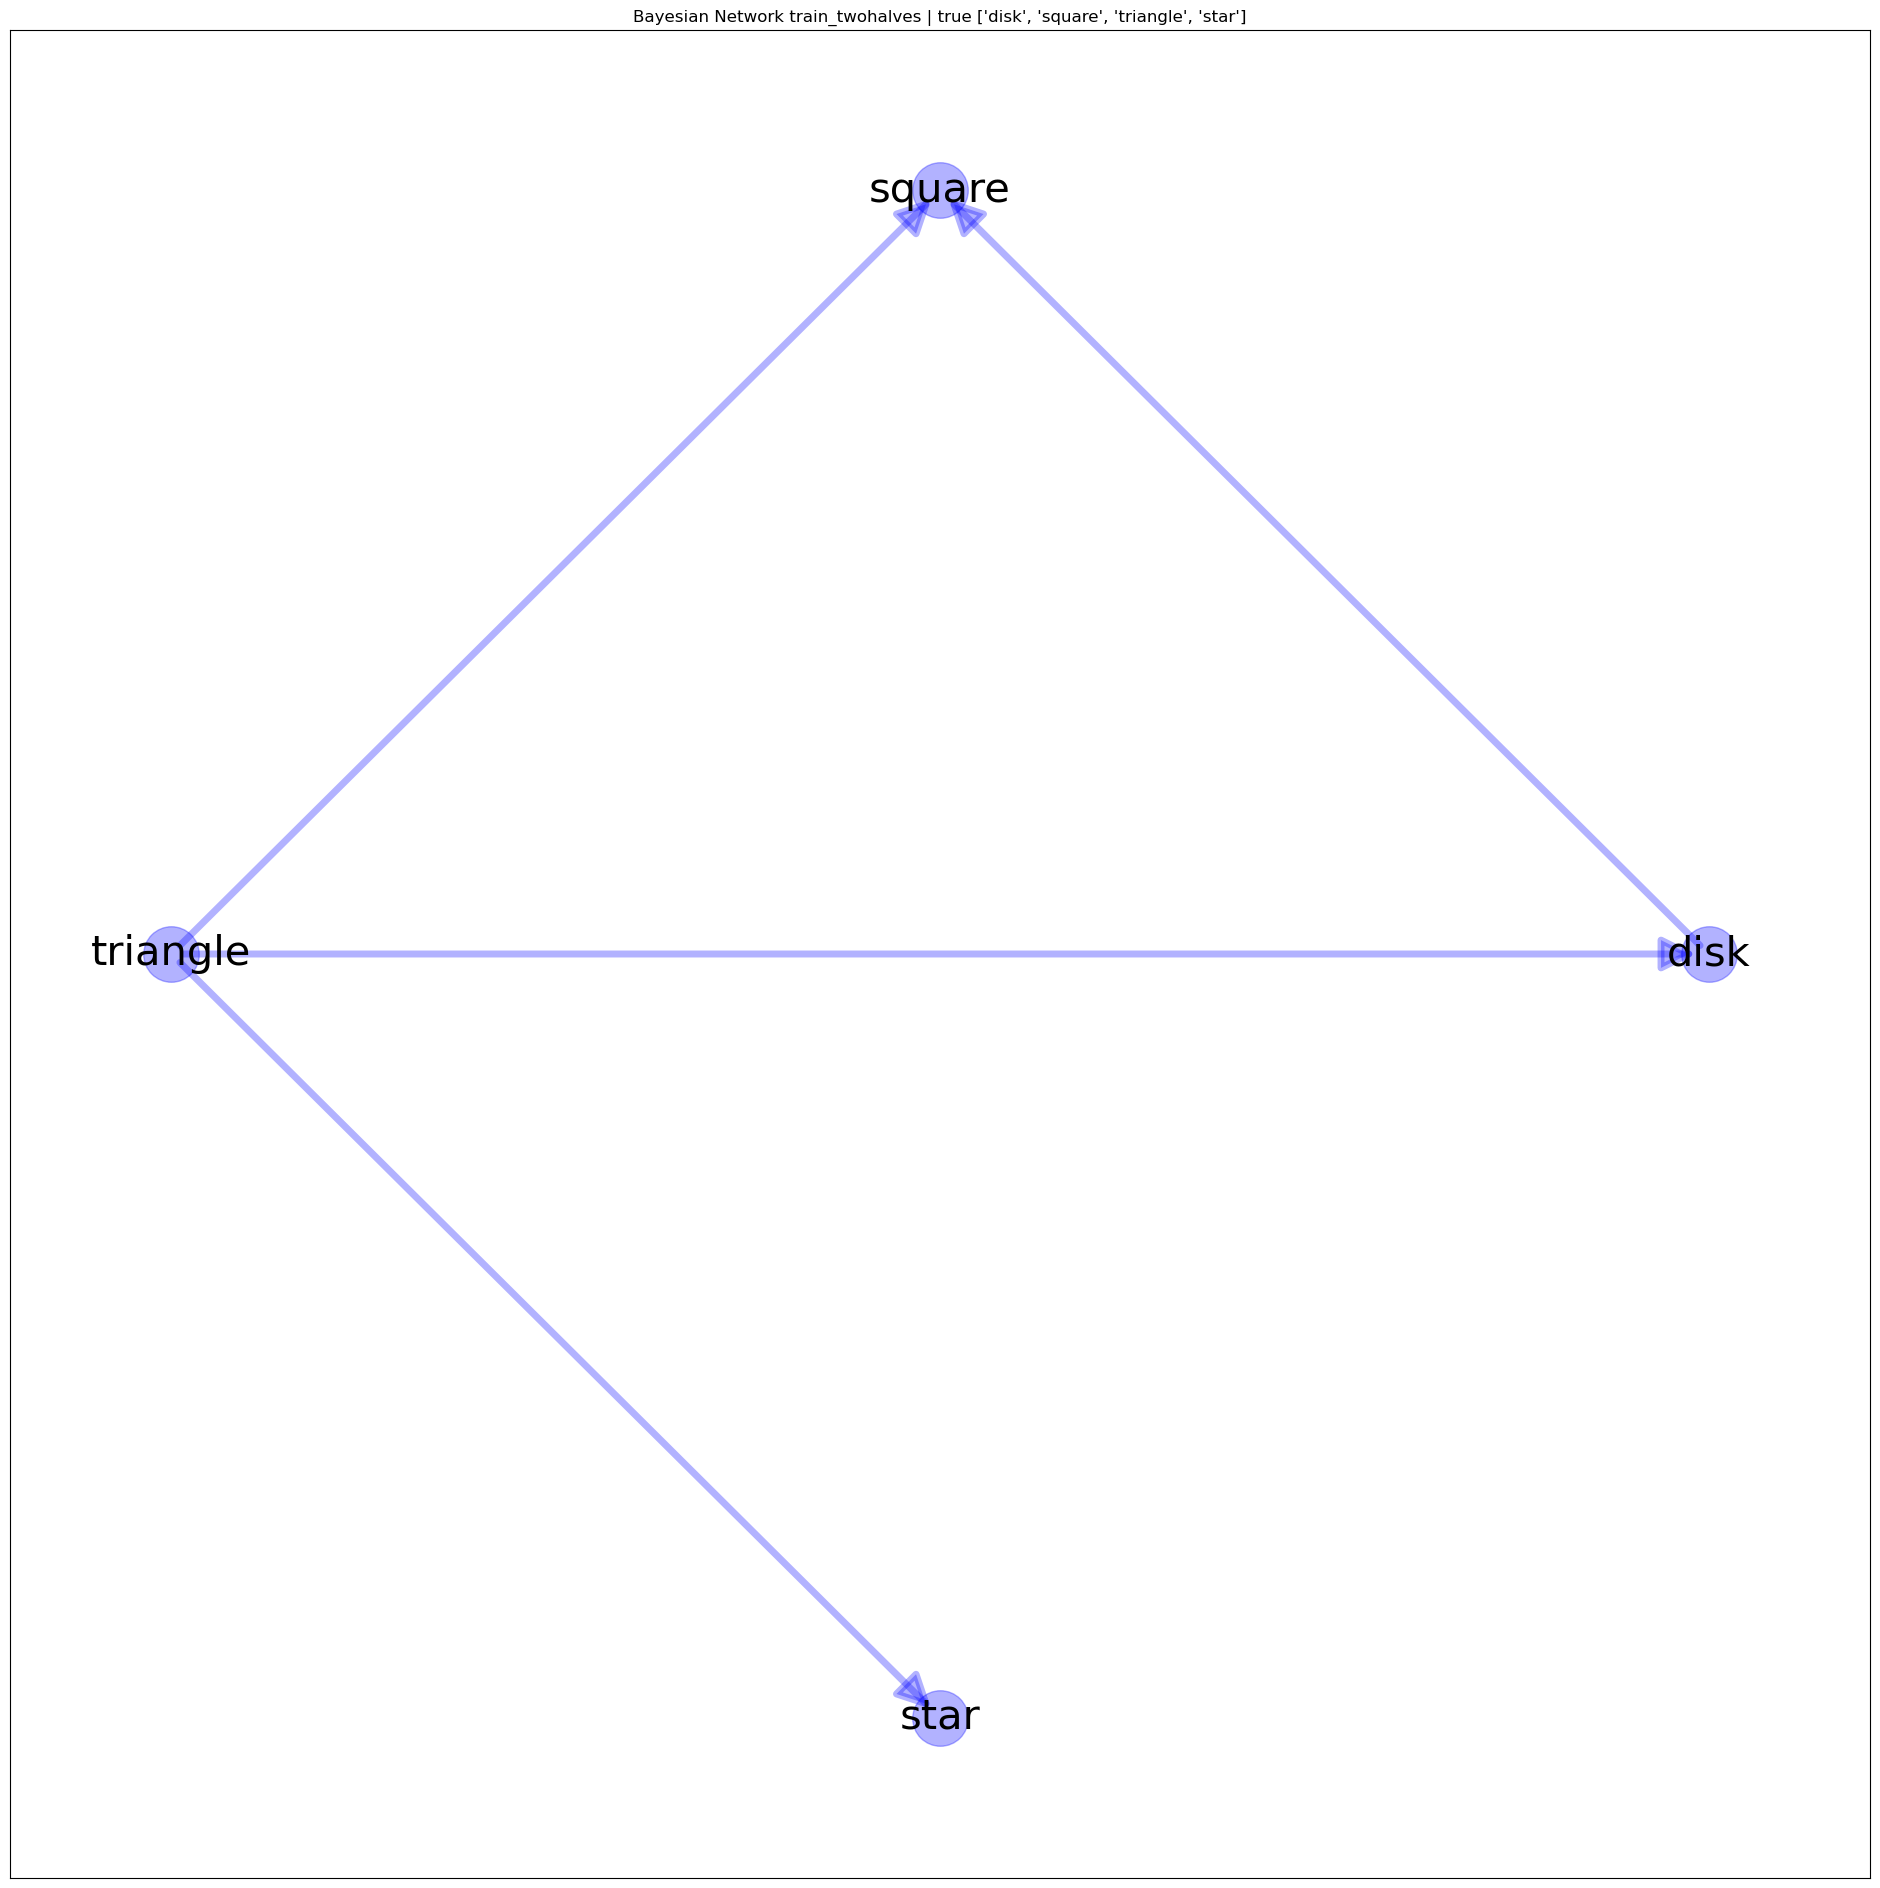

In [60]:
plt.figure(3,figsize=(24,24)) 
draw_graph(bayesian_network['model_edges'], node_text_size=30, edge_tickness=5, graph_layout='circular', title=f'Bayesian Network {variant} | true {shapes[:K_calc]}')

In [64]:
variant = "full_twohalves"

cutoff = X.shape[0] // 2
first_half_data = X[:cutoff]
last_half_data = X[cutoff:]
first_half_ls = y[:cutoff]
last_half_ls = y[cutoff:]

input_size = np.prod(X.shape[1:])
num_classes = y.shape[1]
hidden_size = 100
batch_size = 128
learning_rate = 1e-3
num_epochs = 200

clf = BinaryRelevance(classifier=FfnClf(input_size, hidden_size, num_classes, batch_size, device, learning_rate, num_epochs, verbose=False))
clf.fit(first_half_data, first_half_ls)
preds_last_half = clf.predict(last_half_data)

clf = BinaryRelevance(classifier=FfnClf(input_size, hidden_size, num_classes, batch_size, device, learning_rate, num_epochs, verbose=False))
clf.fit(last_half_data, last_half_ls)
preds_first_half = clf.predict(first_half_data)


In [65]:
preds_first = np.asarray(preds_first_half.todense())
preds_last = np.asarray(preds_last_half.todense())
preds_combined = np.vstack((preds_first, preds_last))
errors = y - preds_combined
error_df = pd.DataFrame(errors, columns = shapes[:K_calc])

In [66]:
error_df.to_csv(f'bn_shapes_error_{variant}.csv', index=False)

In [67]:
bayesian_network = bn.structure_learning.fit(error_df)

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).


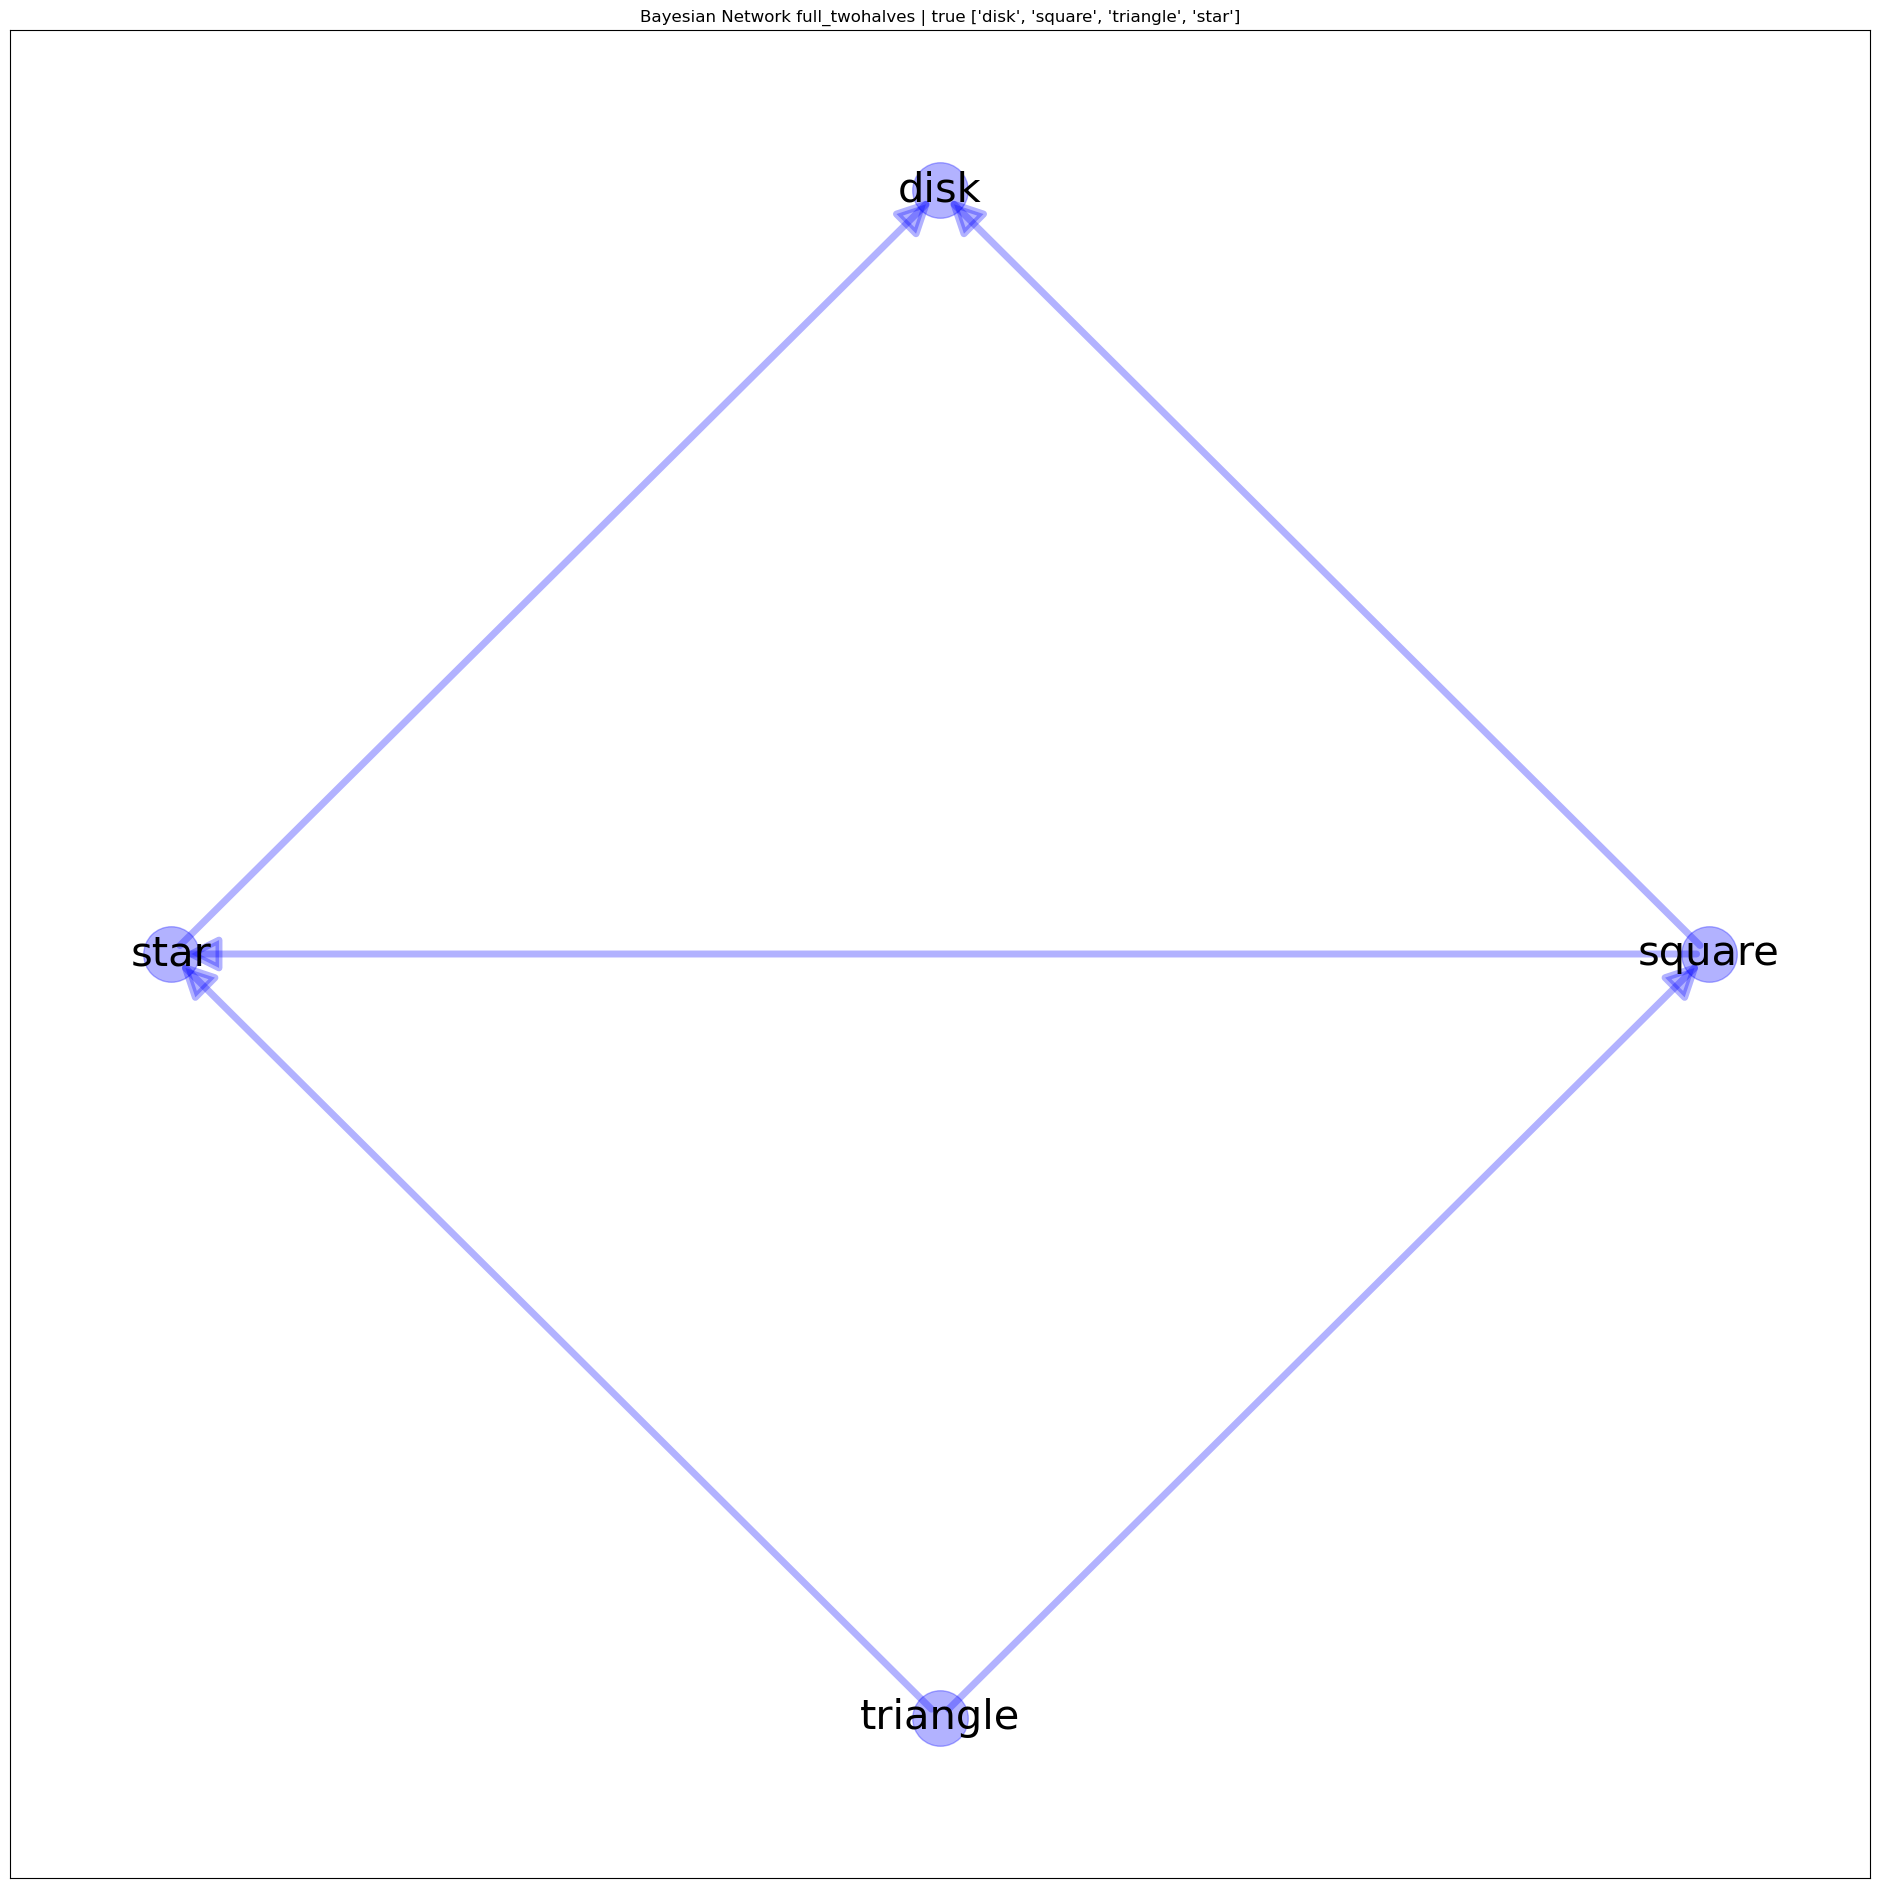

In [68]:
plt.figure(3,figsize=(24,24)) 
draw_graph(bayesian_network['model_edges'], node_text_size=30, edge_tickness=5, graph_layout='circular', title=f'Bayesian Network {variant} | true {shapes[:K_calc]}')

In [69]:
variant = "full"

input_size = np.prod(X.shape[1:])
num_classes = y.shape[1]
hidden_size = 100
batch_size = 128
learning_rate = 1e-3
num_epochs = 200

clf = BinaryRelevance(classifier=FfnClf(input_size, hidden_size, num_classes, batch_size, device, learning_rate, num_epochs, verbose=False))
clf.fit(X, y)
preds = clf.predict(X)


In [70]:
errors = y - np.asarray(preds_combined)
error_df = pd.DataFrame(errors, columns = shapes[:K_calc])

In [71]:
error_df.to_csv(f'bn_shapes_error_{variant}.csv', index=False)

In [72]:
bayesian_network = bn.structure_learning.fit(error_df)

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).


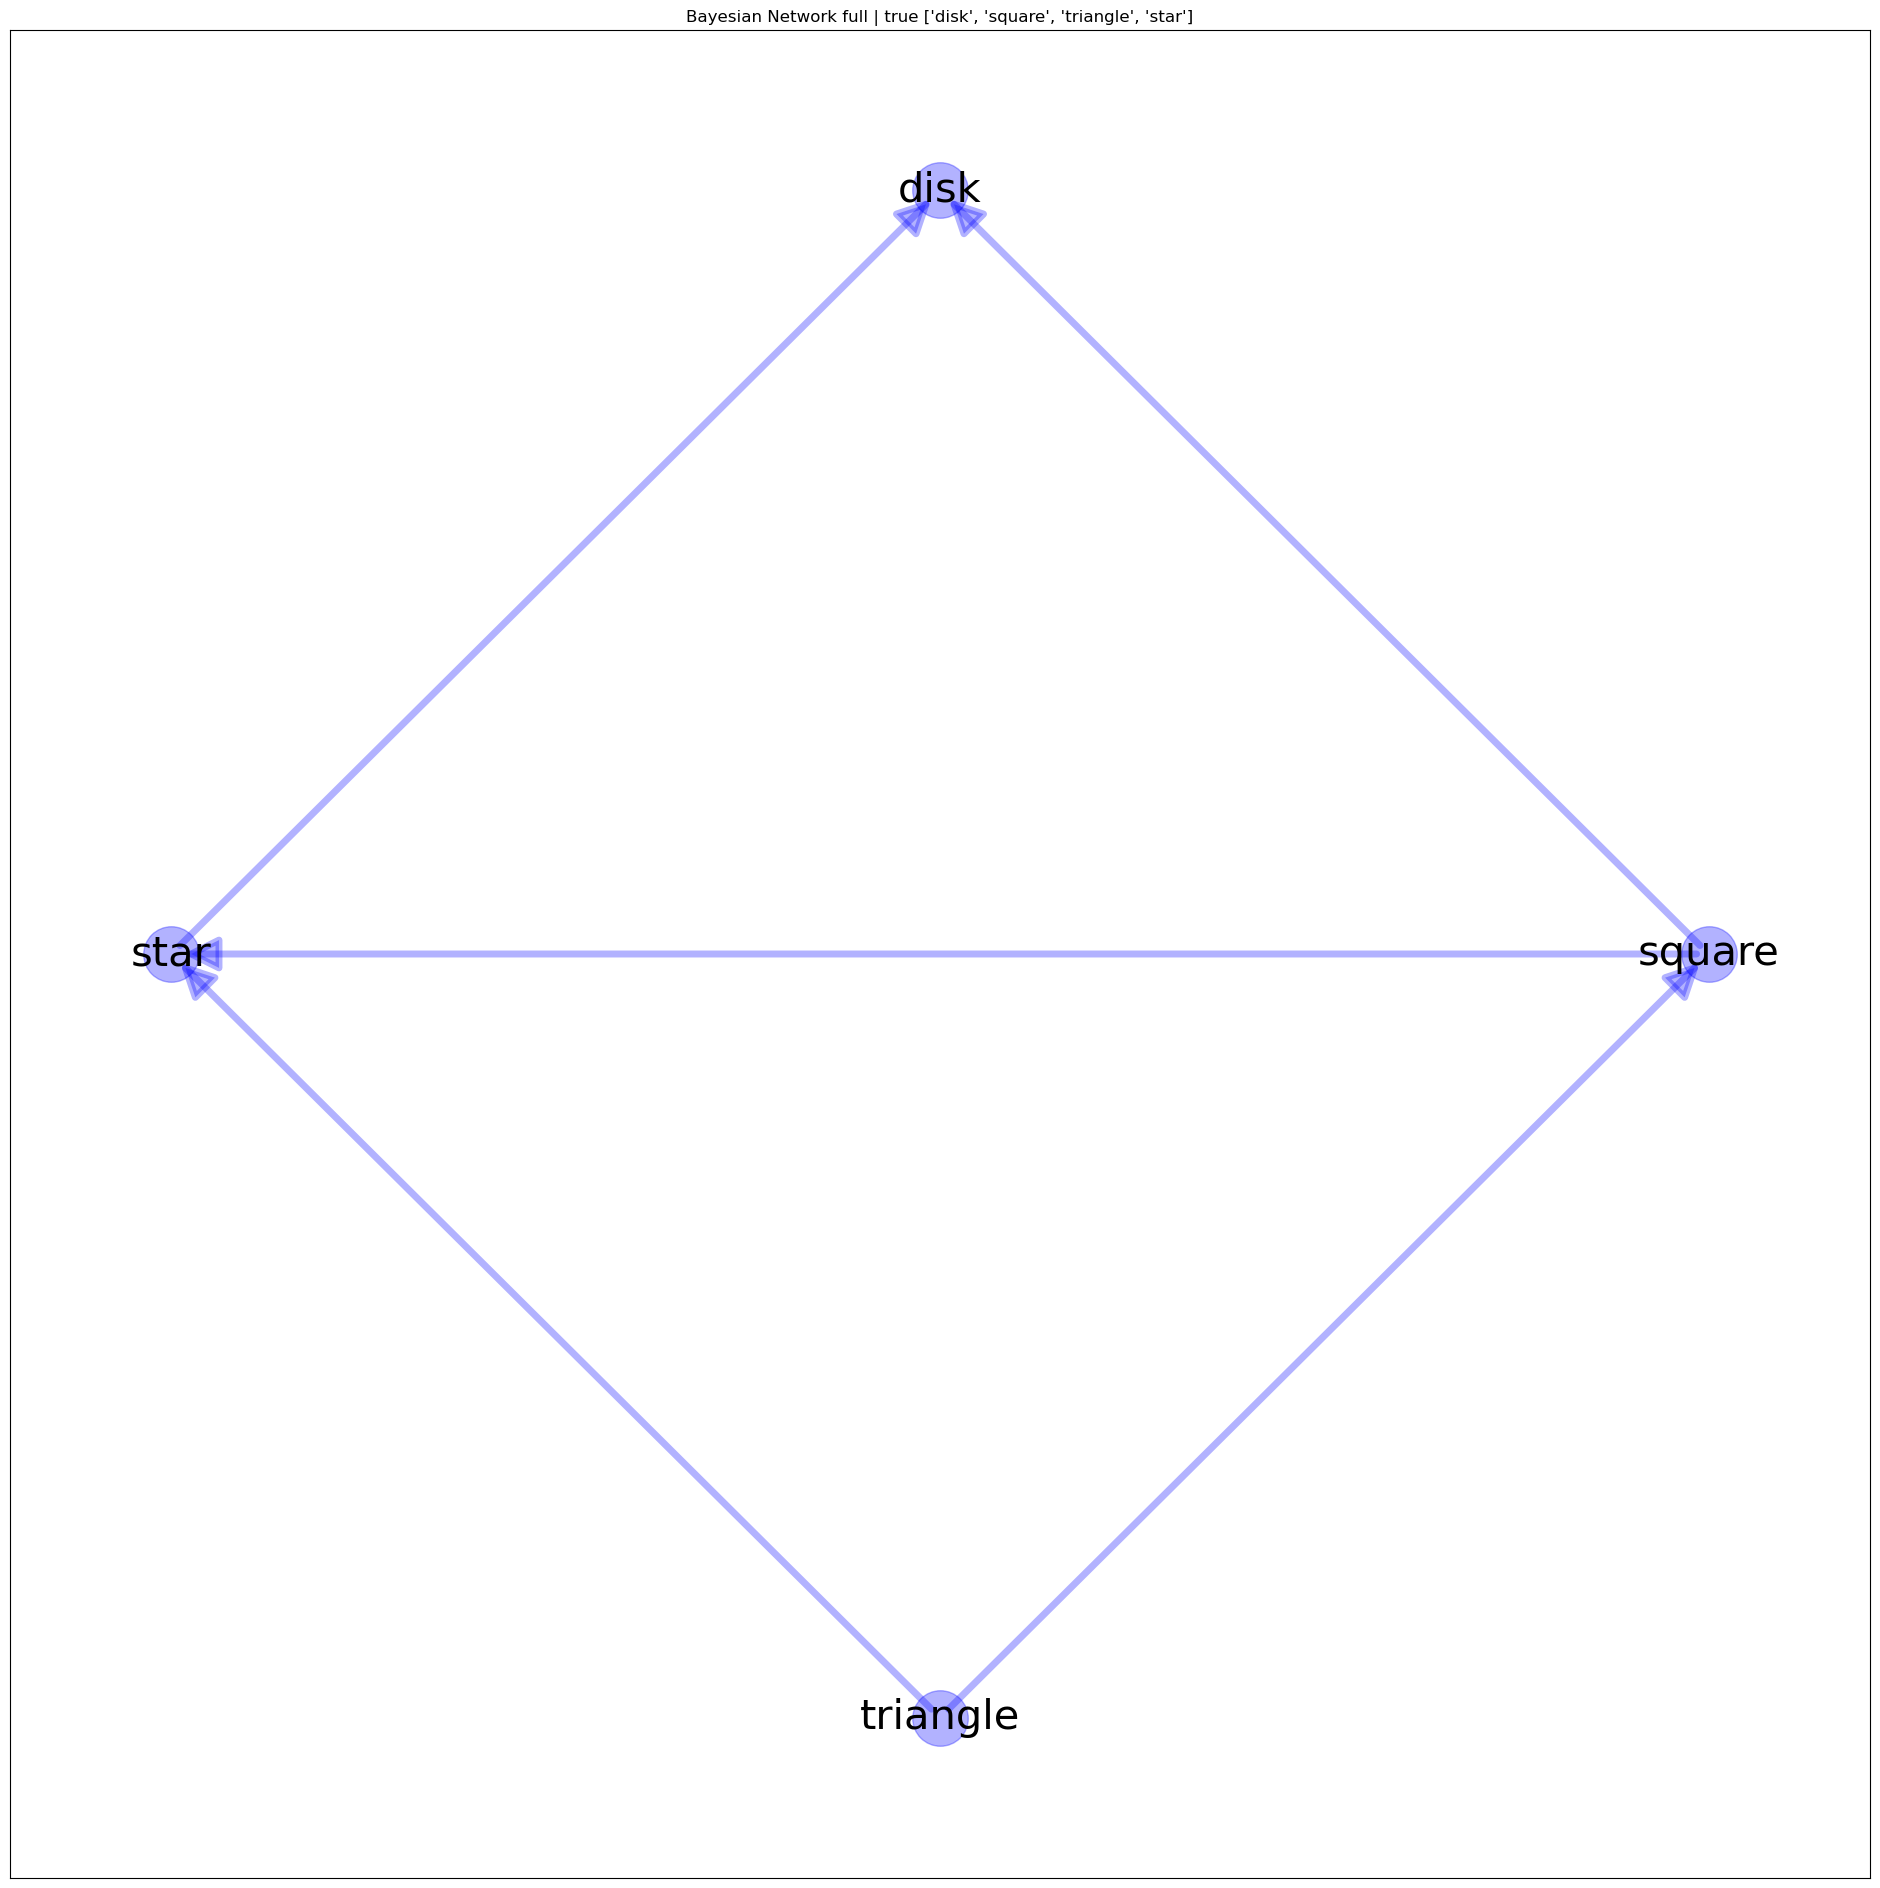

In [73]:
plt.figure(3,figsize=(24,24)) 
draw_graph(bayesian_network['model_edges'], node_text_size=30, edge_tickness=5, graph_layout='circular', title=f'Bayesian Network {variant} | true {shapes[:K_calc]}')